### Maman 11 Question3

Recording:

[Recording of Q3]https://drive.google.com/file/d/1EGRSKRVSLbcY7203OLefXddExjmh129q/view?usp=sharing


# 1. MyScalar class

In [4]:
import torch
import pprint

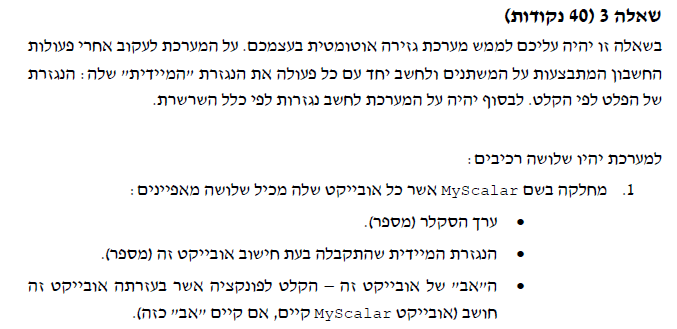

In [47]:
class MyScalar:
    
    def __init__(self, val, grad = torch.tensor(0), parent = None):

      assert torch.is_tensor(val), f"MyScalar supports only a tensor value!"
      assert torch.is_tensor(grad), f"MyScalar supports only a tensor gradient!"
      assert isinstance(parent, (MyScalar, type(None))), f"MyScalar supports only a tensor as parent!"

      self._value_ = val
      self._grad_ = grad
      self._parent_ = parent


    @property
    def val(self):
      return self._value_

    @property
    def grad(self):
      return self._grad_
    
    @property
    def parent(self):
      return self._parent_

    def __str__(self):
     return f"Value = {self._value_}, \t\tGrad = {self._grad_}"

    def extended_info(self):
     return f"MyScalar ID = ({id(self)}). Value = {self._value_}, Grad = {self._grad_}, Parent ID = ({id(self._parent_)})"


# 2. MyMath Static Class

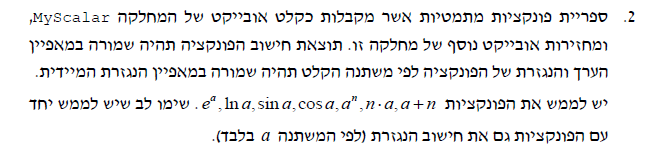

In [75]:
class MyMath(object):

    @staticmethod
    def sum(sclr, n):
        assert isinstance(sclr, MyScalar), f"MyMath sum sopports only MyScalar summation"
        res = sclr.val + n
        grad = torch.tensor(1)
        return MyScalar(res, grad, sclr)

    @staticmethod
    def mul(sclr, n):
        assert isinstance(sclr, MyScalar), f"MyMath mul sopports only MyScalar typed multiplier"
        res = sclr.val * n
        grad = torch.tensor(n)
        return MyScalar(res, grad, sclr)

    @staticmethod
    def pow(sclr, power):
        assert isinstance(sclr, MyScalar), f"MyMath pow sopports only MyScalar typed base"
        res = sclr.val ** power
        grad = power *  (sclr.val ** (power -1))
        return MyScalar(res, grad, sclr)

    @staticmethod
    def cos(sclr):
        assert isinstance(sclr, MyScalar), f"MyMath cos sopports only MyScalar input"
        res = torch.cos(sclr.val)
        grad = -torch.sin(sclr.val)
        return MyScalar(res, grad, sclr)

    @staticmethod
    def sin(sclr):
        assert isinstance(sclr, MyScalar), f"MyMath sin sopports only MyScalar input"
        res = torch.sin(sclr.val)
        grad = torch.cos(sclr.val)
        return MyScalar(res, grad, sclr)

    @staticmethod
    def ln(sclr):
        assert isinstance(sclr, MyScalar), f"MyMath ln sopports only MyScalar input"
        res = torch.log(sclr.val)
        grad = 1/sclr.val
        return MyScalar(res, grad, sclr)

    @staticmethod
    def exp(sclr):
        assert isinstance(sclr, MyScalar), f"MyMath exp sopports only MyScalar typed power"
        res = torch.exp(sclr.val)
        grad = torch.exp(sclr.val)
        return MyScalar(res, grad, sclr)


# 3. Get Gradient implementation

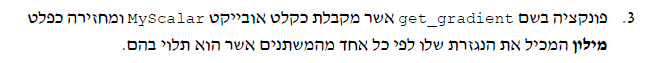

In [76]:
"""
An internal recursive function that gets:
sclr : MyScalar
results : dictionary
partial_grad : a partial gradient

during calculation it updates a dictionary of partial derivatives as values (the objects by whom the partial derivation is done are the keys)
and returns the gradient
"""
def get_gradient_internal(sclr, results, partial_grad):
  assert isinstance(sclr, MyScalar), f"get_gradient_internal expects a sclr of type MyScalar as input!"
  assert isinstance(results, dict), f"get_gradient_internal expects results of type dictionary as input!"
  assert torch.is_tensor(partial_grad), f"get_gradient_internal expects partial_grad to be a tensor!"
  # print(partial_grad)

  results[sclr] = partial_grad

  if sclr.parent is None:
    return partial_grad
  
  return get_gradient_internal(sclr.parent, results, partial_grad * sclr.grad)

In [77]:
def get_gradient(sclr):
   assert isinstance(sclr, (MyScalar, type(None))), f"get_gradient expects an input of type MyScalar"
   res = dict()
   partial_grad = get_gradient_internal(sclr, res, torch.tensor(1))
   return res

In [78]:
def print_grad(results):
  assert isinstance(results, dict), f"print_grad expects results of type dictionary as input!"
  for key in results:
    print(str(key))
    print(f"Partial derivative = {results[key]}\n")

# Testing

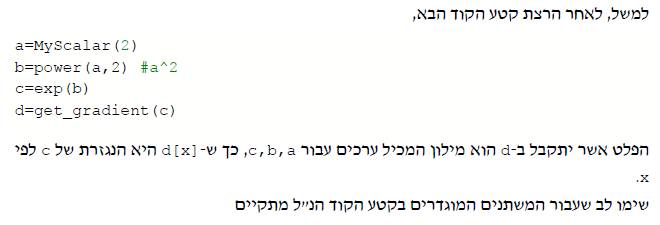

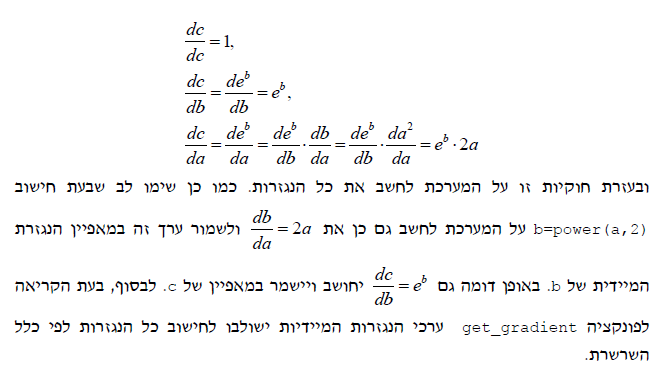

**My get gradient results**

In [84]:
my_manipulations = dict()
my_parents = dict()

my_leaf_key = "a=(2)"
my_manipulations[my_leaf_key] = MyScalar(torch.tensor([2.], requires_grad=True))
my_parents[my_leaf_key] = None

b_key = "b=(2^2)"
my_manipulations[b_key] = MyMath.pow(my_manipulations[my_leaf_key], 2)
my_parents[b_key] = my_leaf_key

c_key = "c=(e^4)"
my_manipulations["c=(e^4)"] = MyMath.exp(my_manipulations[b_key])
my_parents[c_key] = b_key

d_key = "d=sin(e^4)"
my_manipulations[d_key] = MyMath.sin(my_manipulations[c_key])
my_parents[d_key] = c_key

e_key = "e=cos(d)"
my_manipulations[e_key] = MyMath.cos(my_manipulations[d_key])
my_parents[e_key] = d_key

f_key = "f=e+56"
my_manipulations[f_key] = MyMath.sum(my_manipulations[e_key], 56)
my_parents[f_key] = e_key

g_key = "g=f * 9"
my_manipulations[g_key] = MyMath.mul(my_manipulations[f_key], 9)
my_parents[g_key] = f_key

h_key = "h=ln(g)"
my_manipulations[h_key] = MyMath.ln(my_manipulations[g_key])
my_parents[h_key] = g_key

key_for_grad = h_key

In [85]:
result = get_gradient(my_manipulations[key_for_grad])

In [86]:
print("\n\n++++++++++++++++ My Grad Partial Derivatives ++++++++++++++++")
for key in my_manipulations:
  print("Value [", key, "], = ", my_manipulations[key].val, f", \t\t\tD[{key_for_grad}]/D[{key}] = ", result[my_manipulations[key]])



++++++++++++++++ My Grad Partial Derivatives ++++++++++++++++
Value [ a=(2) ], =  tensor([2.], requires_grad=True) , 			D[h=ln(g)]/D[a=(2)] =  tensor([-1.1455], grad_fn=<MulBackward0>)
Value [ b=(2^2) ], =  tensor([4.], grad_fn=<PowBackward0>) , 			D[h=ln(g)]/D[b=(2^2)] =  tensor([-0.2864], grad_fn=<MulBackward0>)
Value [ c=(e^4) ], =  tensor([54.5981], grad_fn=<ExpBackward0>) , 			D[h=ln(g)]/D[c=(e^4)] =  tensor([-0.0052], grad_fn=<MulBackward0>)
Value [ d=sin(e^4) ], =  tensor([-0.9288], grad_fn=<SinBackward0>) , 			D[h=ln(g)]/D[d=sin(e^4)] =  tensor([0.0142], grad_fn=<MulBackward0>)
Value [ e=cos(d) ], =  tensor([0.5988], grad_fn=<CosBackward0>) , 			D[h=ln(g)]/D[e=cos(d)] =  tensor([0.0177], grad_fn=<MulBackward0>)
Value [ f=e+56 ], =  tensor([56.5988], grad_fn=<AddBackward0>) , 			D[h=ln(g)]/D[f=e+56] =  tensor([0.0177], grad_fn=<MulBackward0>)
Value [ g=f * 9 ], =  tensor([509.3894], grad_fn=<MulBackward0>) , 			D[h=ln(g)]/D[g=f * 9] =  tensor([0.0020], grad_fn=<MulBackward0>)


In [88]:
print("\n\n++++++++++++++++ My Grad Derivatives According To Parent++++++++++++++++")

for key in my_manipulations:
  # Print grad according to parent
  print("Value [", key, "], = ", my_manipulations[key].val, f", \t\tD[{key}] / D[{my_parents[key]}] = ", my_manipulations[key].grad)



++++++++++++++++ My Grad Derivatives According To Parent++++++++++++++++
Value [ a=(2) ], =  tensor([2.], requires_grad=True) , 		D[a=(2)] / D[None] =  tensor(0)
Value [ b=(2^2) ], =  tensor([4.], grad_fn=<PowBackward0>) , 		D[b=(2^2)] / D[a=(2)] =  tensor([4.], grad_fn=<MulBackward0>)
Value [ c=(e^4) ], =  tensor([54.5981], grad_fn=<ExpBackward0>) , 		D[c=(e^4)] / D[b=(2^2)] =  tensor([54.5981], grad_fn=<ExpBackward0>)
Value [ d=sin(e^4) ], =  tensor([-0.9288], grad_fn=<SinBackward0>) , 		D[d=sin(e^4)] / D[c=(e^4)] =  tensor([-0.3707], grad_fn=<CosBackward0>)
Value [ e=cos(d) ], =  tensor([0.5988], grad_fn=<CosBackward0>) , 		D[e=cos(d)] / D[d=sin(e^4)] =  tensor([0.8009], grad_fn=<NegBackward0>)
Value [ f=e+56 ], =  tensor([56.5988], grad_fn=<AddBackward0>) , 		D[f=e+56] / D[e=cos(d)] =  tensor(1)
Value [ g=f * 9 ], =  tensor([509.3894], grad_fn=<MulBackward0>) , 		D[g=f * 9] / D[f=e+56] =  tensor(9)
Value [ h=ln(g) ], =  tensor([6.2332], grad_fn=<LogBackward0>) , 		D[h=ln(g)] / D[

**Auto Grad gradient results**

In [90]:
manipulations = dict()
parents = dict()

leaf_key = "a=(2)"
manipulations[leaf_key] = torch.tensor([2.], requires_grad=True)
parents[leaf_key] = None

b1_key = "b=(2^2)"
manipulations[b1_key] = manipulations[leaf_key] ** 2
parents[b1_key] = leaf_key

c1_key = "c=(e^4)"
manipulations["c=(e^4)"] = torch.exp(manipulations[b1_key])
parents[c1_key] = b1_key

d1_key = "d=sin(e^4)"
manipulations[d1_key] = torch.sin(manipulations[c1_key])
parents[d1_key] = c1_key

e1_key = "e=cos(sin(e^4))"
manipulations[e1_key] = torch.cos(manipulations[d1_key])
parents[e1_key] = d1_key

f1_key = "f=e+56"
manipulations[f1_key] = manipulations[e1_key] + 56
parents[f1_key] = e1_key

g1_key = "g=f * 9"
manipulations[g1_key] = manipulations[f1_key] * 9
parents[g1_key] = f_key

h1_key = "h=ln(g)"
manipulations[h1_key] = torch.log(manipulations[g1_key])
parents[h1_key] = g1_key

key_for_grad = h1_key

In [93]:
for key in manipulations:
  manipulations[key].retain_grad()

manipulations[key_for_grad].backward(retain_graph=True)

print("\n\n++++++++++++++++ Auto Grad Partial Derivatives ++++++++++++++++")
for key in manipulations:
  print("Value [", key, "], = ", manipulations[key], f", \tD[{key_for_grad}] / D[{key}] = ", manipulations[key].grad)



++++++++++++++++ Auto Grad Partial Derivatives ++++++++++++++++
Value [ a=(2) ], =  tensor([2.], requires_grad=True) , 	D[h=ln(g)] / D[a=(2)] =  tensor([-1.1455])
Value [ b=(2^2) ], =  tensor([4.], grad_fn=<PowBackward0>) , 	D[h=ln(g)] / D[b=(2^2)] =  tensor([-0.2864])
Value [ c=(e^4) ], =  tensor([54.5981], grad_fn=<ExpBackward0>) , 	D[h=ln(g)] / D[c=(e^4)] =  tensor([-0.0052])
Value [ d=sin(e^4) ], =  tensor([-0.9288], grad_fn=<SinBackward0>) , 	D[h=ln(g)] / D[d=sin(e^4)] =  tensor([0.0142])
Value [ e=cos(sin(e^4)) ], =  tensor([0.5988], grad_fn=<CosBackward0>) , 	D[h=ln(g)] / D[e=cos(sin(e^4))] =  tensor([0.0177])
Value [ f=e+56 ], =  tensor([56.5988], grad_fn=<AddBackward0>) , 	D[h=ln(g)] / D[f=e+56] =  tensor([0.0177])
Value [ g=f * 9 ], =  tensor([509.3894], grad_fn=<MulBackward0>) , 	D[h=ln(g)] / D[g=f * 9] =  tensor([0.0020])
Value [ h=ln(g) ], =  tensor([6.2332], grad_fn=<LogBackward0>) , 	D[h=ln(g)] / D[h=ln(g)] =  tensor([1.])


In [94]:
# Clear previous grad
for key in manipulations:
  manipulations[key].grad = None

print("\n\n++++++++++++++++ Auto Grad Gradients ++++++++++++++++")

for key in manipulations:
  # Call Backward to get derivatives of current func
  manipulations[key].backward(retain_graph=True)

  # Extract grad according to parent
  grad = 0 if parents[key] == None else  manipulations[parents[key]].grad
  print("Value [", key, "], = ", manipulations[key], f", \tD[{key}]/D[{parents[key]}] = ", grad)

  # Clear previous grad
  for key in manipulations:
    manipulations[key].grad = None



++++++++++++++++ Auto Grad Gradients ++++++++++++++++
Value [ a=(2) ], =  tensor([2.], requires_grad=True) , 	D[a=(2)]/D[None] =  0
Value [ b=(2^2) ], =  tensor([4.], grad_fn=<PowBackward0>) , 	D[b=(2^2)]/D[a=(2)] =  tensor([4.])
Value [ c=(e^4) ], =  tensor([54.5981], grad_fn=<ExpBackward0>) , 	D[c=(e^4)]/D[b=(2^2)] =  tensor([54.5981])
Value [ d=sin(e^4) ], =  tensor([-0.9288], grad_fn=<SinBackward0>) , 	D[d=sin(e^4)]/D[c=(e^4)] =  tensor([-0.3707])
Value [ e=cos(sin(e^4)) ], =  tensor([0.5988], grad_fn=<CosBackward0>) , 	D[e=cos(sin(e^4))]/D[d=sin(e^4)] =  tensor([0.8009])
Value [ f=e+56 ], =  tensor([56.5988], grad_fn=<AddBackward0>) , 	D[f=e+56]/D[e=cos(sin(e^4))] =  tensor([1.])
Value [ g=f * 9 ], =  tensor([509.3894], grad_fn=<MulBackward0>) , 	D[g=f * 9]/D[f=e+56] =  tensor([9.])
Value [ h=ln(g) ], =  tensor([6.2332], grad_fn=<LogBackward0>) , 	D[h=ln(g)]/D[g=f * 9] =  tensor([0.0020])
